<a href="https://colab.research.google.com/github/Larbi96-enet/Cure-EMG-signal-classification/blob/main/dataclassificatin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # charts
import scipy as sp
from scipy.fft import fft, ifft
from scipy import signal
import csv
from numpy import savetxt
import os
import glob

# New Section

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

from time import time

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/data/EMG-data.csv')
df.drop('time',inplace=True,axis=1)
df.head()

,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,label
0,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0,1
1,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0,1
2,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0,1
3,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0,1
4,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0,1


In [ ]:
df['class'].value_counts()

0    2725157
6     253009
5     251733
4     251570
1     250055
3     249494
2     243193
7      13696
Name: class, dtype: int64

In [ ]:
len(df['label'].value_counts())


36

In [ ]:
subjects_data=df.groupby(['label','class'])


In [ ]:
import numpy as np

def rms(data): #root mean square
      return  np.sqrt(np.mean(data**2,axis=0))  

def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=0)),axis=0)


def zero_crossing(data):
    return np.argmax(np.diff(np.sign(data),axis=0),axis=0)



In [ ]:
start=time()
features=subjects_data.agg([ 'min','max',np.ptp,rms,zero_crossing,abs_diffs_signal])

end=time()
print('feature calculation time of one subject one class')
print((end-start)/(36*7))

feature calculation time of one subject one class
0.020026464310903398


In [ ]:
features=features.reset_index()
features.head()

label class channel1  ...  channel8                               
                   min  ...       rms zero_crossing abs_diffs_signal
0     1     0 -0.00116  ...  0.000134           1.0          0.71288
1     1     1 -0.00005  ...  0.000014          67.0          0.00921
2     1     2 -0.00111  ...  0.000150           0.0          0.11696
3     1     3 -0.00087  ...  0.000161          24.0          0.11869
4     1     4 -0.00020  ...  0.000083          55.0          0.04984

[5 rows x 50 columns]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,recall_score,roc_auc_score, precision_score,f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold,StratifiedKFold

In [ ]:
classifiers = [#manhattan,4,distance
    KNeighborsClassifier(metric='manhattan',weights='distance',n_neighbors=4),
    SVC(C=3, gamma=0.04), #2,0.01
    DecisionTreeClassifier(criterion= 'entropy',max_depth= 7,max_features= 'auto',random_state= 20),
    RandomForestClassifier(bootstrap=False,max_depth=8,max_features='sqrt',min_samples_leaf=1,
                          min_samples_split=2,n_estimators=100),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    LogisticRegression(C=0.05, penalty='l2')]

In [ ]:
import warnings
warnings.filterwarnings('always') 
clf_performace={'accuracy':[],'f1score':[],'training_time':[],'testing_time':[]}
for clfs in classifiers:
    #pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    accuracy=[]
    f1score=[]
    recall=[]
    precision=[]
    training_time=[]
    testing_time=[]
    for i in range(1,37):
        train=features[features['label']!=i]
        test=features[features['label']==i]
        X_train=train.iloc[:,2::].values
        X_test=test.iloc[:,2::].values
        y_train=train['class']
        y_test=test['class']
        training_start=time()
        clf = make_pipeline(StandardScaler(), clfs)
        clf.fit(X_train, y_train)
        training_end=time()
        testing_start=time()
        y_pred=clf.predict(X_test)
        testing_end=time()
        acc=accuracy_score(y_test,y_pred)
        recall.append(recall_score(y_test,y_pred,average='macro'))
        #precision.append(precision_score(y_test,y_pred,average='macro'))
        f1score.append(f1_score(y_test,y_pred,average='macro'))
        accuracy.append(acc)
        training_time.append(training_end-training_start)
        testing_time.append(testing_end-testing_start)
        #print('subject {} accuracy is {}'.format(i,acc))
    print(name,np.mean(accuracy))
    clf_performace['accuracy'].append(accuracy)
    clf_performace['f1score'].append(f1score)
    clf_performace['training_time'].append(np.mean(training_time))
    clf_performace['testing_time'].append(np.mean(testing_time))

KNeighborsClassifier 0.894345238095238
SVC 0.8983134920634921
DecisionTreeClassifier 0.7648809523809526
RandomForestClassifier 0.8591269841269842


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier 0.851686507936508
GaussianNB 0.8348214285714286
LinearDiscriminantAnalysis 0.8159722222222223


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated.

LogisticRegression 0.8551587301587301


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring(

In [ ]:
a=np.mean(np.array(clf_performace['accuracy']),axis=1)
f=np.mean(np.array(clf_performace['f1score']),axis=1)

In [ ]:
df=pd.DataFrame(np.stack((a,f)),columns=['KNN','SVM','DT','RF','GB','NB','LDA','LR'],
            index=['Accuracy','F1-score'])
df

,KNN,SVM,DT,RF,GB,NB,LDA,LR
Accuracy,0.894345,0.898313,0.764881,0.859127,0.851687,0.834821,0.815972,0.855159
F1-score,0.863757,0.869048,0.708234,0.821098,0.812996,0.791005,0.771412,0.817378


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


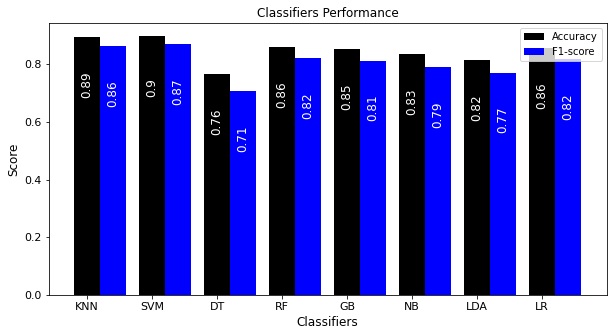

In [ ]:
classifier=df.loc['F1-score'].index
y_pos = np.arange(len(classifier))
w=0.4

plt.figure(figsize=(10,5))
plt.bar(y_pos,df.loc['Accuracy'].values,align='center',width=w,label='Accuracy',color='black')
plt.bar(y_pos+w,df.loc['F1-score'].values,align='center',width=w,label='F1-score',color='blue')

ya=df.loc['Accuracy'].values
for index, value in enumerate(ya):
    plt.text(index-0.1,value-0.2, str(np.round(value,2)),rotation=90,color='white',fontsize=12)

yf=df.loc['F1-score'].values
for index, value in enumerate(yf):
    plt.text(index+w-0.1,value-0.2, str(np.round(value,2)),rotation=90,color='white',fontsize=12)


plt.xticks(y_pos, classifier,fontsize=11)
plt.yticks(fontsize=11)
plt.ylabel('Score',fontsize=12)
plt.xlabel('Classifiers',fontsize=12)
plt.title('Classifiers Performance',fontsize=12)
plt.legend()
plt.savefig('result.eps',dip=300)

In [ ]:
pd.DataFrame(zip(np.array(clf_performace['training_time'])*65,np.array(clf_performace['testing_time'])),
            columns=['training_time','testing_time'],
            index=['KNN','SVM','DT','RF','GB','NB','LDA','LR'])

,training_time,testing_time
KNN,0.125004,0.001258
SVM,0.695223,0.000551
DT,0.240576,0.000262
RF,11.061587,0.008663
GB,117.196339,0.000999
NB,0.136434,0.000519
LDA,0.466243,0.000451
LR,4.821649,0.000368
